#**Modern face recognition with deep learning**

<img src='https://perso.esiee.fr/~caninr/IA/iadl.jpg' type='image'>

## **Introduction**

Longtemps considérée comme science-fiction, la reconnaissance faciale est aujourd'hui une application fondamentale des réseaux de neurones. 
<br><br>

***Mais qu'est-ce que la reconnaissance faciale ?***<br>
La reconnaissance faciale est un système qui grâce à l'intelligence artificielle - plus précisément l'apprentissage profond - permet d'identifier tout individu à l'aide d'une simple image de son visage.
<br><br>
***Comment fonctionne-t-il concrètement ?***<br>
Lorsque l'on veut identifier le visage d'une personne, il faut tout d'abord procéder à un preprocess de l'image à analyser (détection des contours du visage, encodage du visage en fonction de différents points de mesures placés sur le visage...). Ensuite, un réseau de neurones, préalablement entraîné sur une quantité suffisante de visages (dont celui que l'on cherche à identifier), va effectuer une prédiction sur l'identité de la personne. 

***Et cette méthode est-elle précise ?***<br>
Bien évidemment, des erreurs d'appréciation sont possibles de la part du modèle effectuant la prédiction. Néanmoins, avec un réseau de neurones adapté ainsi qu'une quantité conséquente de données d'entraînement, on atteint facilement des précisions avoisinant les 99 voire 100%.

In [ ]:
# importation des différents modules utilisés dans ce projet
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import os
import keras
import sklearn

## **1. Détection des contours du visage**



La première étape de notre pré-traitement des images est la détection des contours des visages. Pour cela, nous allons utiliser CNN Face Detector de dlib.


<img src="https://www.baseapp.com/wp-content/uploads/2018/04/temp-1.jpg" height=500>

#### [Fonctions fournies]

In [ ]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/models.zip
!unzip -o models.zip

--2021-04-23 04:48:52--  https://perso.esiee.fr/~najmanl/FaceRecognition/models.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100563300 (96M) [application/zip]
Saving to: ‘models.zip.2’

models.zip.2        100%[===================>]  95.90M  21.3MB/s    in 5.4s    

2021-04-23 04:48:59 (17.9 MB/s) - ‘models.zip.2’ saved [100563300/100563300]

Archive:  models.zip
  inflating: models/shape_predictor_68_face_landmarks.dat  
  inflating: __MACOSX/models/._shape_predictor_68_face_landmarks.dat  
  inflating: models/mmod_human_face_detector.dat  
  inflating: __MACOSX/models/._mmod_human_face_detector.dat  
  inflating: models/dlib_face_recognition_resnet_model_v1.dat  
  inflating: __MACOSX/models/._dlib_face_recognition_resnet_model_v1.dat  
  inflating: models/shape_predictor_5_face_landmarks.dat  
  inflating: __MACOSX/models/._shape_pre

In [ ]:
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')

def face_locations(image, model="hog"):
    
    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10
            
    matches = detector(image,1)
    rects   = []
    
    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))
        
    return rects

In [ ]:
def extract_faces(image, model="hog"):
    
    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = face_locations(gray, model)
    faces = []
    
    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)
            
    return faces

In [ ]:
def show_grid(faces, figsize=(12,3)):

    n = len(faces)
    cols = 7
    rows = int(np.ceil(n/cols))
    
    fig, ax = plt.subplots(rows,cols, figsize=figsize)

    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            if i == n:
                 break
            ax[r,c].imshow(faces[i])
            ax[r,c].axis('off')
            #ax[r,c].set_title('size: ' + str(faces[i].shape[:2]))

In [ ]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):
    
    imagePaths = []
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)
    
    return imagePaths

### Application au dataset fourni

Tout d'abord, on importe le dataset qui va nous permettre d'entraîner notre modèle. C'est celui-ci que nous allons prétraiter.

In [ ]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/data.zip
!unzip -o data.zip

Ensuite, imagePaths permet de lister le chemin d'accès de l'ensemble des images du dossier **data** :

In [ ]:
imagePaths = list_images("data")

On crée la liste du nom de toutes les personnes de notre dataset :

In [ ]:
# Créer automatiquement un array contenant les noms des différentes personnes.
# Cela est possible car notre dataset est séparé sous forme de dossiers.

# Fonction récupérant listant le contenu d'un répertoire
def get_directories(root):
  return os.listdir(root)

# Array des noms
names = np.array(get_directories("/content/data"))
print(names)

['claire_dearing' 'john_hammond' 'ellie_sattler' 'ian_malcolm'
 'alan_grant' 'owen_grady']


À présent, nous allons extraire le visage de chaque image tout en lui associant un label.

In [ ]:
faces = [] # Liste des visages
labels = [] # Liste des labels associés aux visages

for face_path in imagePaths: # On parcourt l'ensemble des images
  Appended = False # Booléen vérifiant si le visage a été labelisé
  face = cv2.imread(face_path) # Lecture de l'image
  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) # Conversion de l'espace de couleur
  face = extract_faces(face, "cnn") # Extraction du visage via CNN
  if len(face) != 0 :
    i = 0
    while i<names.shape[0] and not(Appended):
      if face_path.find(names[i]) !=-1: # On regarde quel nom de la liste names contient le path de l'image
        label = np.zeros(len(names))
        label[i] = 1 # One-hot encoding de chaque classe
        labels.append(label) # On ajoute le label correspondant
        faces.append(face[0]) # On ne prend que le premier visage extrait
        Appended = True
      i += 1

On stocke ces deux listes dans un fichier à l'aide de pickle afin de pouvoir les réutiliser par la suite, vierges de toutes modifications effectuées dans cette première partie : 

In [ ]:
import pickle
dataset = (faces,labels)
with open('dataset.pickle', 'wb') as p:
    pickle.dump(dataset, p)

On normalise les visages (division par 255) tout en convertissant les deux listes en numpy array :

In [ ]:
faces = np.array(faces) / 255
labels = np.array(labels)

On divise nos listes en train set et test set (70/30%) à l'aide de la méthode **train_test_split** de sklearn. On active le mélange du dataset à l'aide de **shuffle=True** :

In [ ]:
from sklearn.model_selection import train_test_split
train_faces, test_faces, train_labels, test_labels = train_test_split(faces, labels, test_size=0.3, shuffle=True)

Il est maintenant temps d'élaborer notre réseau de neurones. Les premières couches seront des layers de convolution et de max pooling, caractéristiques du traitement d'images en IA. En effet, des couches denses dès le début seraient innapropriées face aux dimensions parfois imposantes d'une images. On connecte ensuite la sortie des layers de convolution et de max-pooling à un fully-connected layer après avoir appliqué **Flatten()**.

In [ ]:
from keras import layers
from keras import models

# Layers de convolution et de max-pooling
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))

# On connecte la sortie à un fully-connected layer
model.add(layers.Flatten())
model.add(layers.Dropout(.5)) # Régularisation par dropout pour réduire l'overfitting
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(len(names),activation='softmax')) # On a 6 catégories possibles dans la classification. 
# On utilise softmax pour le dernier layer car nous sommes dans une multiclass classification

from keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
# categorical_crossentropy est caractéristique des multiclass classifications

# On entraîne le modèle sur les données précedemment prétraitées et on teste les performances du modèle sur le batch de test. 
history = model.fit(train_faces, train_labels, epochs = 30, validation_data=(test_faces, test_labels))

Epoch 1/30
5/5 [==============================] - 1s 76ms/step - loss: 3.1567 - acc: 0.1925 - val_loss: 1.7748 - val_acc: 0.1587
Epoch 2/30
5/5 [==============================] - 0s 32ms/step - loss: 1.7355 - acc: 0.2841 - val_loss: 1.7035 - val_acc: 0.2540
Epoch 3/30
5/5 [==============================] - 0s 33ms/step - loss: 1.6059 - acc: 0.3985 - val_loss: 1.5868 - val_acc: 0.3810
Epoch 4/30
5/5 [==============================] - 0s 33ms/step - loss: 1.4122 - acc: 0.5057 - val_loss: 1.4053 - val_acc: 0.4286
Epoch 5/30
5/5 [==============================] - 0s 33ms/step - loss: 1.2024 - acc: 0.5399 - val_loss: 1.3321 - val_acc: 0.4444
Epoch 6/30
5/5 [==============================] - 0s 34ms/step - loss: 1.0649 - acc: 0.5624 - val_loss: 1.0137 - val_acc: 0.6825
Epoch 7/30
5/5 [==============================] - 0s 35ms/step - loss: 0.7783 - acc: 0.7417 - val_loss: 0.8596 - val_acc: 0.6825
Epoch 8/30
5/5 [==============================] - 0s 34ms/step - loss: 0.5434 - acc: 0.8156 - val

Maintenant que le réseau de neurones est entraîné, nous pouvons tracer ses performances sur le training et le testing. 

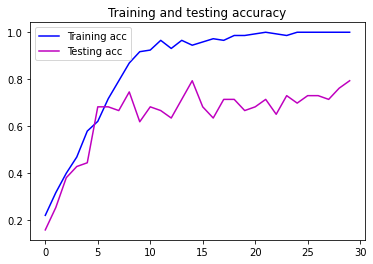

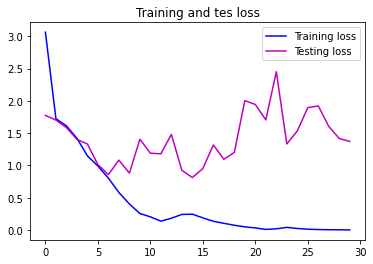

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Testing acc')
plt.title('Training and testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Testing loss')
plt.title('Training and tes loss')
plt.legend()

plt.show()

**CONCLUSION** : On remarque un très clair overfitting du modèle notamment dû au manque évident de données de training.

###Réduire l'overfitting [méthode peu efficace]

Pour améliorer les performances du réseau de neurones, une solution qui vient immédiatement à l'esprit est d'augmenter le nombre d'images à l'aide de la data augmentation de keras. On procéderait alors de la manière suivante.

In [ ]:
from keras.preprocessing import image
datagen = image.ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      fill_mode='nearest')

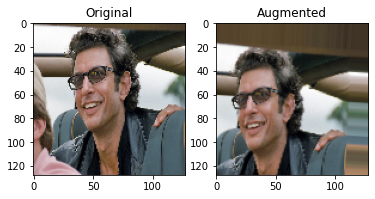

In [ ]:
# Choix de l'image à augmenter
img = image.load_img("data/ian_malcolm/00000036.jpg", target_size=(128, 128))

# Conversion à un Numpy array avec une shape de (128, 128, 3)
x = image.img_to_array(img)

# Reshape en (1, 128, 128, 3)
x = x.reshape((1,) + x.shape)

batch = datagen.flow(x, batch_size=1)[0]

fig = plt.figure()

fig.add_subplot(121)
plt.imshow(img)
plt.title("Original")

fig.add_subplot(122)
plt.imshow(image.array_to_img(batch[0]))
plt.title("Augmented")

plt.show()

=> Néanmoins, les différents pré-traitements qui vont être effectués par la suite sur les images vont lisser les modifications apportées par la data augmentation. Ce n'est donc pas la solution la plus optimale.

## **2. Estimation de la pose**

Nous avons isolé les visages dans notre image. À présent, pour tenir compte des différentes orientations de visages dans l'espace -ayant un aspect totalement différent pour un ordinateur-, nous allons calculer les différents points de repère du visage. L'idée de base est de localiser 68 points spécifiques qui existent sur chaque visage : le haut du menton, le bord extérieur de chaque œil, le bord intérieur de chaque sourcil... Ensuite, il suffit de faire pivoter, de mettre à l'échelle et de cisailler l'image pour que les yeux et la bouche soient centrés le mieux possible. La reconnaissance des visages sera ainsi plus précise.

<img src="https://camo.githubusercontent.com/266dc85552e9de96ef393f9785b8bf404a2f85f0ab18633d320e89d9579a6326/68747470733a2f2f797576616c6e69726b696e2e6769746875622e696f2f6173736574732f696d672f70726f6a656374732f66696e645f666163655f6c616e646d61726b735f7465617365722e6a7067" height=400>

### [Fonctions fournies]

In [ ]:
pose68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):
    
    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05
    
    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [ ]:
def shape_to_coords(shape):
    return np.float32([[p.x, p.y] for p in shape.parts()])

In [ ]:
TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

INNER_EYES_AND_BOTTOM_LIP = np.array([39, 42, 57])
OUTER_EYES_AND_NOSE = np.array([36, 45, 33])

In [ ]:
def align_faces(images, landmarks, idx=INNER_EYES_AND_BOTTOM_LIP):
    faces = []
    for (img, marks) in zip(images, landmarks):
        imgDim = img.shape[0]
        coords = shape_to_coords(marks)
        H = cv2.getAffineTransform(coords[idx], imgDim * MINMAX_TEMPLATE[idx])
        warped = cv2.warpAffine(img, H, (imgDim, imgDim))
        faces.append(warped)
    return faces

### Application au dataset fourni :

Tout d'abord, on récupère notre dataset enregistré à l'aide de pickle.

On peut ensuite calculer les différents landmarks des visages du dataset et aligner les différents visages.

In [ ]:
landmarks = face_landmarks(datasetp[0])

new_faces = []
for (face,shape) in zip(faces, landmarks):
    canvas = face.copy()
    coords = shape_to_coords(shape)
    for p in coords:
        cv2.circle(canvas, (p[0],p[1]), 1, (0, 0, 255), -1)
    new_faces.append(canvas)


aligned = align_faces(datasetp[0], landmarks)

dataset_aligned = (aligned,labels)

Comme dans la première partie, on normalise les visages tout en convertissant nos deux listes en numpy array. Puis, on divise nos listes en train set et test set (70/30%) à l'aide de la méthode **train_test_split** de sklearn. On active le mélange du dataset à l'aide de **shuffle=True** :

In [ ]:
# Normalisation des visages + conversion en numpy array
aligned = np.array(aligned) / 255
labels = np.array(labels)

# Division du train set et du test set - 70%/30%

from sklearn.model_selection import train_test_split
train_faces, test_faces, train_labels, test_labels = train_test_split(aligned, labels, test_size=0.3, shuffle=True)


On ré-entraîne le même modèle que tout à l'heure sur les visages alignés : 

In [ ]:
from keras import layers
from keras import models

# On commence par des layers de convolution et de max pooling, caractéristiques du traitement d'images en IA
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64,(3,3),activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128,(3,3),activation='relu'))

# On connecte la sortie à un fully-connected layer
model2.add(layers.Flatten())
model2.add(layers.Dropout(.5)) # Régularisation par dropout pour réduire l'overfitting
model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dense(6,activation='softmax')) # On a 6 catégories possibles dans la classification. 
# On utilise softmax pour le dernier layer car nous sommes dans une multiclass classification

from keras import optimizers

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
# categorical_crossentropy est caractéristique des multiclass classifications

# On entraîne le modèle sur les données précédemment prétraitées et on teste les performances du modèle sur le batch de test. 
history2 = model2.fit(train_faces, train_labels, epochs = 30, validation_data=(test_faces, test_labels))

Epoch 1/30
5/5 [==============================] - 1s 77ms/step - loss: 2.0161 - acc: 0.2021 - val_loss: 1.7833 - val_acc: 0.1587
Epoch 2/30
5/5 [==============================] - 0s 36ms/step - loss: 1.7553 - acc: 0.3013 - val_loss: 1.6738 - val_acc: 0.2698
Epoch 3/30
5/5 [==============================] - 0s 34ms/step - loss: 1.7046 - acc: 0.2616 - val_loss: 1.6291 - val_acc: 0.3810
Epoch 4/30
5/5 [==============================] - 0s 34ms/step - loss: 1.5519 - acc: 0.3964 - val_loss: 1.4321 - val_acc: 0.3810
Epoch 5/30
5/5 [==============================] - 0s 36ms/step - loss: 1.1583 - acc: 0.5977 - val_loss: 1.0225 - val_acc: 0.7143
Epoch 6/30
5/5 [==============================] - 0s 33ms/step - loss: 0.7129 - acc: 0.7496 - val_loss: 1.0688 - val_acc: 0.7143
Epoch 7/30
5/5 [==============================] - 0s 35ms/step - loss: 0.4980 - acc: 0.8369 - val_loss: 1.1792 - val_acc: 0.7143
Epoch 8/30
5/5 [==============================] - 0s 33ms/step - loss: 0.4193 - acc: 0.8940 - val

Maintenant que le réseau de neurones est entraîné, nous pouvons tracer ses performances sur le training et le testing.

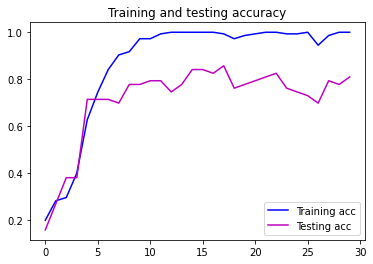

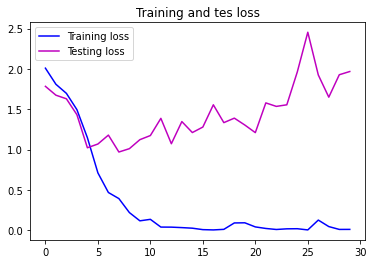

In [ ]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Testing acc')
plt.title('Training and testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Testing loss')
plt.title('Training and tes loss')
plt.legend()

plt.show()

**CONCLUSION** : L'accuracy de notre testing ne semble pas avoir drastiquement augmenté par rapport à la première partie. L'alignement des visages ne semble  donc pas produire de réelles améliorations dans la lutte contre l'overfitting.

## **3. Encodage du visage**

Ainsi, la solution précédente ne semble pas être efficace afin d'améliorer l'efficacité de notre modèle de prédiction. La deuxième solution étudiée dans cette partie est celle du face encoding. Cela consiste à entraîner un réseau à générer 128 mesures réellement caractéristiques pour chaque visage. 
Comme ce processus d'apprentissage nécessite beaucoup de données et de puissance de calcul, nous allons utiliser le réseau pré-entraîné de l'équipe de OpenFace pour obtenir le face encoding d'un visage.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/encoding.png" height=500>

### [Fonctions fournies]

In [ ]:
cnn_encoder = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

def face_encoder(faces):
    
    landmarks = face_landmarks(faces)
    
    if not isinstance(faces, list):
        return np.array(cnn_encoder.compute_face_descriptor(faces,landmarks))
    else:
        return np.array([cnn_encoder.compute_face_descriptor(f,l) for f,l in zip(faces,landmarks)])

### Encodage des visages du dataset fourni

Tout d'abord, on récupère notre dataset enregistré à l'aide de pickle.

In [ ]:
with open('dataset.pickle', 'rb') as p:
    datasetp2 = pickle.load(p) # accéder au tuple de listes stocké dans dataset.pickle

On peut ensuite utiliser **face_encoder()** afin de calculer l'encodage de tous les visages du dataset.

In [ ]:
encoded_faces = face_encoder(datasetp2[0])

On ré-effectue ensuite les mêmes étapes que précédemment.

In [ ]:
# Conversion en numpy array
encoded_faces = np.array(encoded_faces)
labels = np.array(labels)

# Division du train set et du test set - 70%/30%

from sklearn.model_selection import train_test_split
train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, labels, test_size=0.3, shuffle=True)

On retire les convnets et on n'utilise plus que des layers denses.

In [ ]:
from keras import layers
from keras import models


model3 = models.Sequential()

model3.add(layers.Flatten())
model3.add(layers.Dense(64,activation='relu'))
model3.add(layers.Dropout(.5)) # Régularisation par dropout pour réduire l'overfitting
model3.add(layers.Dense(128,activation='relu'))
model3.add(layers.Dense(256,activation='relu'))
model3.add(layers.Dense(len(names),activation='softmax')) # On a 6 catégories possibles dans la classification. 
# On utilise softmax pour le dernier layer car nous sommes dans une multiclass classification

from keras import optimizers

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
# categorical_crossentropy est caractéristique des multiclass classifications

# On entraîne le modèle sur les données précedemment prétraitées et on teste les performances du modèle sur le batch de test. 
history3 = model3.fit(train_faces, train_labels, epochs = 50, validation_data=(test_faces, test_labels))

Epoch 1/50
5/5 [==============================] - 1s 45ms/step - loss: 1.7952 - acc: 0.2118 - val_loss: 1.7761 - val_acc: 0.1746
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.7390 - acc: 0.3203 - val_loss: 1.7492 - val_acc: 0.1746
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.6843 - acc: 0.2949 - val_loss: 1.7263 - val_acc: 0.1746
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.6422 - acc: 0.2715 - val_loss: 1.7034 - val_acc: 0.1746
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 1.6295 - acc: 0.2741 - val_loss: 1.6347 - val_acc: 0.1746
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 1.4965 - acc: 0.3449 - val_loss: 1.5493 - val_acc: 0.3810
Epoch 7/50
5/5 [==============================] - 0s 9ms/step - loss: 1.4771 - acc: 0.4062 - val_loss: 1.4400 - val_acc: 0.5556
Epoch 8/50
5/5 [==============================] - 0s 9ms/step - loss: 1.3338 - acc: 0.4885 - val_lo

Maintenant que le réseau de neurones est entraîné, nous pouvons tracer ses performances sur le training et le testing.

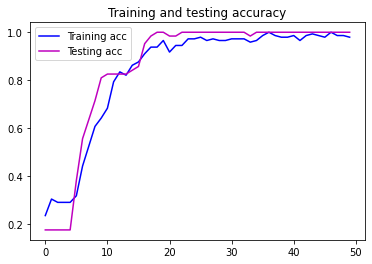

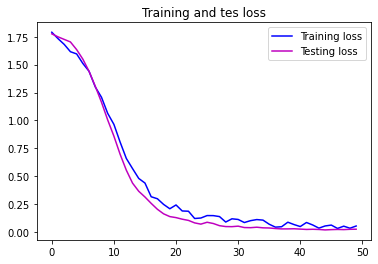

In [ ]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Testing acc')
plt.title('Training and testing accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Testing loss')
plt.title('Training and tes loss')
plt.legend()

plt.show()

**CONCLUSION** : L'accuracy du testing s'est grandement améliorée : l'overfitting a été réduit. Le modèle que nous avons à présent est fonctionnel et efficace pour la reconnaissance faciale.

## **4. Reconnaissance faciale**

Pour cette dernière étape, il nous suffit de choisir un classificateur parmi différents modèles proposés : KNN, SVM, Logistic Regression ou celui que l'on a utilisé précédemment. Nous chercherons une précision élevée ainsi qu'une vitesse de traitement très faible.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/test.gif" width=800>

### Test des performances des différents modèles

Nous allons comparer les performances de différents classificateurs de la bibliothèque sklearn à celles de notre réseau créé précédemment.

In [ ]:
### SVM

# Correction des labels pour SVM (le one-hot encoding ne fonctionne pas ici)
new_labels = []
for i in range(labels.shape[0]):
  new_labels.append(np.where(labels[i]==1)[0][0])

# Division du train set et du test set - 70%/30%
from sklearn.model_selection import train_test_split
train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, new_labels, test_size=0.3, shuffle=True)

#Importation du modèle SVM
from sklearn import svm

#Création d'un SVM de type Classifier
modelSVM = svm.SVC()

#Train du modèle
modelSVM.fit(train_faces, train_labels)

#Prédiction de la réponse sur le test_faces
face_pred = modelSVM.predict(test_faces)

#Affichage de l'accuracy (aux alentours de 0.96)
from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(test_labels, face_pred))


Accuracy :  1.0


In [ ]:
### Logistic regression

# Division du train set et du test set - 70%/30%
from sklearn.model_selection import train_test_split
train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, new_labels, test_size=0.3, shuffle=True)

#Importation du modèle Logistic Regression
from sklearn.linear_model import LogisticRegression

#Création d'un SVM de type Classifier
modelLR = LogisticRegression()

#Train du modèle
modelLR.fit(train_faces, train_labels)

#Prédiction de la réponse sur le test_faces
face_pred = modelLR.predict(test_faces)

#Affichage de l'accuracy (aux alentours de 0.97)
from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(test_labels, face_pred))

Accuracy :  0.9365079365079365


In [ ]:
### KNN

# Division du train set et du test set - 70%/30%
from sklearn.model_selection import train_test_split
train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, labels, test_size=0.3, shuffle=True)

#Importation du modèle KNN
from sklearn.neighbors import KNeighborsClassifier

#Création d'un modèle
modelKNN = KNeighborsClassifier(n_neighbors=3)

#Train du modèle
modelKNN.fit(train_faces, train_labels)

#Prédiction de la réponse sur le test_faces
face_pred = modelKNN.predict(test_faces)

#Affichage de l'accuracy (aux alentours de 0.97)
from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(test_labels, face_pred))

Accuracy :  1.0


Afin d'obtenir une accuracy moyenne pour chaque modèle, on effectue plusieurs tours de boucle en entraînant chacun d'entre eux sur un nouveau mélange du dataset. On peut ensuite calculer la moyenne de l'accuracy ainsi que le temps d'exécution -temps que le modèle met pour effectuer une prédiction, training non inclus-.

In [ ]:
# Comparons les performances des différents modèles :
scoreKNN = 0
scoreSVM = 0
scoreLR = 0
scoreOwn = 0
loops = 100 # Nombre de boucles de training (pour avoir une moyenne de l'accuracy)

from sklearn.model_selection import train_test_split

from time import perf_counter # Pour mesurer la vitesse des différents modèles

# KNN
tKNN = 0 # Variable du temps d'exécution pour KNN
for i in range(loops):
  train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, new_labels, test_size=0.3, shuffle=True) # On mélange le dataset à chaque tour de boucle
  modelKNN.fit(train_faces, train_labels) # On entraîne le modèle sur le nouveau split
  tKNN_start = perf_counter() # On stocke le temps de début d'exécution
  scoreKNN += accuracy_score(test_labels, modelKNN.predict(test_faces)) # On ajoute à scoreKNN l'accuracy sur ce batch de testing-ci
  tKNN_stop = perf_counter() # On stocke le temps de fin d'exécution
  tKNN += tKNN_stop - tKNN_start # On ajoute au temps total le temps d'exécution du predict de ce tour de boucle 

# SVM
tSVM = 0
for i in range(loops):
  train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, new_labels, test_size=0.3, shuffle=True)
  modelSVM.fit(train_faces, train_labels)
  tSVM_start = perf_counter()
  scoreSVM += accuracy_score(test_labels, modelSVM.predict(test_faces))
  tSVM_stop = perf_counter()
  tSVM += tSVM_stop - tSVM_start

# LR
tLR = 0
for i in range(loops):
  train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, new_labels, test_size=0.3, shuffle=True)
  modelLR.fit(train_faces, train_labels)
  tLR_start = perf_counter() 
  scoreLR += accuracy_score(test_labels, modelLR.predict(test_faces))
  tLR_stop = perf_counter()
  tLR = tLR_stop - tLR_start

# Notre propre modèle de la partie 3
# On n'effectue qu'une seule itération de l'entraînement de notre précédent modèle.
# En effet, le training est assez long et plusieurs tours de boucles prendraient un temps fou d'exécution (~100s pour 50 tours de boucles)
# Or, ce qui nous intéresse, c'est le temps d'exécution de predict et non le training.
train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, labels, test_size=0.3, shuffle=True)
train_faces = np.array(train_faces)
train_labels = np.array(train_labels)
history3 = model3.fit(train_faces, train_labels, epochs = 50, validation_data=(test_faces, test_labels), verbose=0) 
tOwn_start = perf_counter()
scoreOwn += history3.history['val_acc'][-1] # On récupère la dernière accuracy du testing
tOwn_stop = perf_counter()

# Moyenne de l'accuracy
scoreKNN = scoreKNN / loops 
scoreSVM = scoreSVM / loops
scoreLR  = scoreLR  / loops

# Affichage de l'accuracy
print("KNN Accuracy  : ", scoreKNN)
print("SVM Accuracy  : ", scoreSVM)
print("LR Accuracy   : ", scoreLR)
print("Own Accuracy  : ", scoreOwn, '\n')


# Affichage du temps total d'exécution
print("KNN Time      : ", tKNN, "s")
print("SVM Time      : ", tSVM, "s")
print("LR Time       : ", tLR, "s")
print("Own Time      : ", (tOwn_stop - tOwn_start)*loops, "s")

KNN Accuracy  :  0.9795238095238087
SVM Accuracy  :  0.9688888888888877
LR Accuracy   :  0.9707936507936498
Own Accuracy  :  1.0 

KNN Time      :  0.45012379600211716 s
SVM Time      :  0.16225329700091606 s
LR Time       :  0.00027121100038129953 s
Own Time      :  0.006509100012408453 s


**CONCLUSION** : Les précisions sont assez similaires pour KNN, SVM et la Logistic Regression. Néanmoins, notre propre réseau est nettement plus performant. Du côté du temps d'exécution, la Logistic Regression est largement devant les autres. Toutefois, notre propre réseau a une vitesse de traitement assez correct et assez rapide pour du traitement de vidéos. Ainsi, le réseau de neurones précédemment créé semble être un bon compromis entre vitesse et précision : nous le sélectionnons pour la suite.


### Reconnaissance faciale sur image

À présent que nous disposons d'un modèle entraîné de reconnaissance faciale, il ne nous reste plus qu'à rendre visuelle cette identification.

In [ ]:
def process_frame(image, mode="fast"):
    
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
        
    for rect in matches:
        
        # face landmarks
        landmarks = pose68(gray, rect)
        
        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)
        encoding = np.array(list(encoding))

   
        # face classification
        probability = np.amax(np.array(model3.predict(encoding.reshape(1,128))))*1000 # Confiance du modèle en sa réponse
        predicted_label = np.argmax(np.array(model3.predict(encoding.reshape(1,128))[0])) # Position du label prédit dans la liste names
        label = names[predicted_label] + ' (' + str(np.floor(probability)/10) + '%)' # Affichage du type : Personne (97.0%)

    
        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.50, (0, 255, 0), 2)
        
    return image

In [ ]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/test.zip
!unzip -o test.zip

--2021-04-23 04:50:12--  https://perso.esiee.fr/~najmanl/FaceRecognition/test.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12530126 (12M) [application/zip]
Saving to: ‘test.zip.1’

test.zip.1          100%[===================>]  11.95M  8.18MB/s    in 1.5s    

2021-04-23 04:50:14 (8.18 MB/s) - ‘test.zip.1’ saved [12530126/12530126]

Archive:  test.zip
  inflating: test/lunch_scene.mp4    
  inflating: __MACOSX/test/._lunch_scene.mp4  
  inflating: test/example_03.png     
  inflating: __MACOSX/test/._example_03.png  
  inflating: test/example_02.png     
  inflating: __MACOSX/test/._example_02.png  
  inflating: test/example_01.png     
  inflating: __MACOSX/test/._example_01.png  
  inflating: __MACOSX/._test         


On teste notre fonction sur trois images de test : 5 visages sur 6 sont correctement identifiés (l'erreur étant compréhensible vu la position de la tête de Alan Grant).

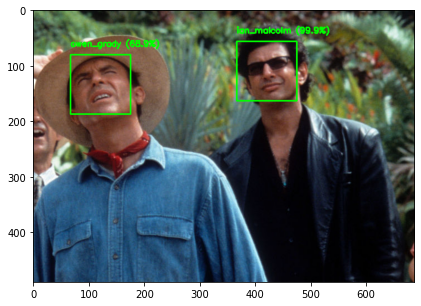

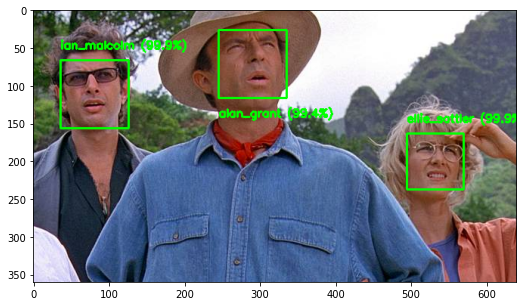

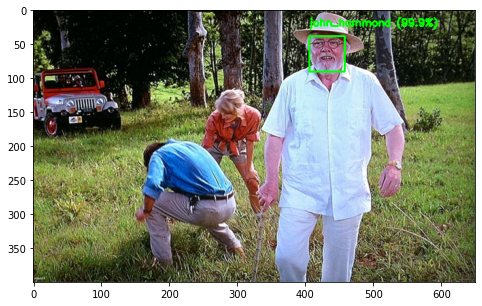

In [ ]:
for image_path in list_images("test"):
  image = cv2.imread(image_path)
  processed = process_frame(image.copy())
  processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(15,5))
  plt.imshow(processed)

### Reconnaissance faciale vidéo

Pour la reconnaissance faciale sur une vidéo, cela est compliqué dans Google Colab. Le meilleur résultat obtenu est un affichage image par image à la suite avec les identifications de visages. Pour plus de rapidité, on va utiliser la Logistic Regression au prix d'une précision moindre.

In [ ]:
def process_frame(image, mode="fast"):
    
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
        
    for rect in matches:
        
        # face landmarks
        landmarks = pose68(gray, rect)
        
        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)
        encoding = np.array(list(encoding))

   
        # face classification
        label = names[modelLR.predict(encoding.reshape(1,128))[0]] # Logistic Regression prediction

        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.50, (0, 255, 0), 2)
        
    return image

In [ ]:
def process_movie(video_name, mode="fast"):
    
    video  = cv2.VideoCapture(video_name)
    
    try:
        
        while True:

            # Grab a single frame of video
            ret, frame = video.read()
            
            # Resize frame of video for faster processing
            frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

            # Quit when the input video file ends or key "Q" is pressed
            key = cv2.waitKey(1) & 0xFF
            if not ret or key == ord("q"):
                break

            # Process frame
            image = process_frame(frame, mode)

            # Display the resulting image
            from google.colab.patches import cv2_imshow
            cv2_imshow(image) 
    
    finally:
        video.release()
        cv2.destroyAllWindows()
        print("Video released")

In [ ]:
# Exécution très longue (> 4mn) !
# process_movie("test/lunch_scene.mp4")

## **5. Construction de notre propre dataset**

À présent, après avoir créé notre propre dataset d'images, nous pouvons tester tout ce que l'on a appliqué jusqu'ici pour obtenir le meilleur rendu possible.

<img src='https://perso.esiee.fr/~caninr/IA/part5.png' width=1000>

### [Fonctions fournies]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import os
import keras
import sklearn

In [ ]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/models.zip
!unzip -o models.zip

--2021-05-26 13:47:46--  https://perso.esiee.fr/~najmanl/FaceRecognition/models.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100563300 (96M) [application/zip]
Saving to: ‘models.zip.1’

models.zip.1         93%[=================>  ]  90.09M  11.2MB/s    eta 1s     ^C
Archive:  models.zip
  inflating: models/shape_predictor_68_face_landmarks.dat  
  inflating: __MACOSX/models/._shape_predictor_68_face_landmarks.dat  
  inflating: models/mmod_human_face_detector.dat  
  inflating: __MACOSX/models/._mmod_human_face_detector.dat  
  inflating: models/dlib_face_recognition_resnet_model_v1.dat  
  inflating: __MACOSX/models/._dlib_face_recognition_resnet_model_v1.dat  
  inflating: models/shape_predictor_5_face_landmarks.dat  
  inflating: __MACOSX/models/._shape_predictor_5_face_landmarks.dat  
  inflating: __MACOSX/._models       


In [ ]:
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')

def face_locations(image, model="hog"):
    
    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10
            
    matches = detector(image,1)
    rects   = []
    
    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))
        
    return rects

In [ ]:
def extract_faces(image, model="hog"):
    
    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = face_locations(gray, model)
    faces = []
    
    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)
            
    return faces

In [ ]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):
    
    imagePaths = []
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)
    
    return imagePaths

In [ ]:
pose68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):
    
    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05
    
    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [ ]:
cnn_encoder = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

def face_encoder(faces):
    
    landmarks = face_landmarks(faces)
    
    if not isinstance(faces, list):
        return np.array(cnn_encoder.compute_face_descriptor(faces,landmarks))
    else:
        return np.array([cnn_encoder.compute_face_descriptor(f,l) for f,l in zip(faces,landmarks)])

### Application :

Importons notre dataset à l'aide de wget et de unzip :

In [ ]:
!wget https://perso.esiee.fr/~caninr/IA/light_dataset.zip
!unzip -o light_dataset.zip # -o permet d'écraser les éventuels précédents fichiers

--2021-05-26 13:48:14--  https://perso.esiee.fr/~caninr/IA/light_dataset.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123353287 (118M) [application/zip]
Saving to: ‘light_dataset.zip.1’

light_dataset.zip.1 100%[===================>] 117.64M  11.3MB/s    in 12s     

2021-05-26 13:48:28 (9.68 MB/s) - ‘light_dataset.zip.1’ saved [123353287/123353287]

Archive:  light_dataset.zip
  inflating: __MACOSX/light_dataset/._calvin  
  inflating: __MACOSX/light_dataset/._raphael  
  inflating: light_dataset/amandine/016.png  
  inflating: __MACOSX/light_dataset/amandine/._016.png  
  inflating: light_dataset/amandine/017.png  
  inflating: __MACOSX/light_dataset/amandine/._017.png  
  inflating: light_dataset/amandine/029.png  
  inflating: __MACOSX/light_dataset/amandine/._029.png  
  inflating: light_dataset/amandine/015.png  
  inflating: __MA

On peut alors obtenir la liste de tous les chemins d'accès des images du dataset.

In [ ]:
imagePaths = list_images("light_dataset")
print(imagePaths)

['light_dataset/yann/026.jpg', 'light_dataset/yann/014.jpg', 'light_dataset/yann/023.jpg', 'light_dataset/yann/024.jpg', 'light_dataset/yann/09.jpg', 'light_dataset/yann/027.jpg', 'light_dataset/yann/029.jpg', 'light_dataset/yann/010.jpg', 'light_dataset/yann/06.jpg', 'light_dataset/yann/030.jpg', 'light_dataset/yann/02.jpg', 'light_dataset/yann/08.jpg', 'light_dataset/yann/015.jpg', 'light_dataset/yann/033.jpg', 'light_dataset/yann/01.jpg', 'light_dataset/yann/017.jpg', 'light_dataset/yann/018.jpg', 'light_dataset/yann/021.jpg', 'light_dataset/yann/034.jpg', 'light_dataset/yann/031.jpg', 'light_dataset/yann/022.jpg', 'light_dataset/yann/028.jpg', 'light_dataset/yann/020.jpg', 'light_dataset/yann/025.jpg', 'light_dataset/yann/016.jpg', 'light_dataset/yann/032.jpg', 'light_dataset/yann/011.jpg', 'light_dataset/yann/019.jpg', 'light_dataset/yann/013.jpg', 'light_dataset/yann/07.jpg', 'light_dataset/yann/012.jpg', 'light_dataset/yann/04.jpg', 'light_dataset/yann/035.jpg', 'light_dataset/c

On crée ensuite notre liste des noms des personnes :

In [ ]:
# Créer automatiquement un array contenant les noms des différentes personnes.
# Cela est possible car notre dataset est séparé sous forme de dossiers.

# Fonction récupérant listant le contenu d'un répertoire
def get_directories(root):
  return os.listdir(root)

# Array des noms
names = np.array(get_directories("/content/light_dataset"))
print(names)

['yann' 'calvin' 'raphael' 'kunter' 'rafa' 'anna' 'melissa' 'pierre'
 'amandine' 'amaury']


On extrait tous les visages et on les labélise :

In [ ]:
# Extraction des visages et de leur label
faces = [] # Liste des visages
labels = [] # Liste des labels associés aux visages

for face_path in imagePaths:
  Appended = False
  face = cv2.imread(face_path) # lecture de l'image
  face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) # conversion de l'espace de couleur
  face = extract_faces(face, "cnn") # Extraction du visage
  if len(face) != 0 :
    i = 0
    while i<names.shape[0] and not(Appended):
      if face_path.find(names[i]) !=-1: # On regarde quel nom contient le path de l'image
        label = np.zeros(len(names))
        label[i] = 1 # One-hot encoding de chaque classe
        labels.append(label) # On ajoute le label correspondant
        faces.append(face[0]) # On ne prend que le premier visage extrait
        Appended = True
      i += 1


  

On encode alors tous les visages :

In [ ]:
encoded_faces = face_encoder(faces)

On entraîne notre réseau de neurones sur ce nouveau dataset :

In [ ]:
### Notre propre réseau de neurones :

# Division du train set et du test set - 70%/30%
encoded_faces = np.array(encoded_faces)
labels = np.array(labels)
from sklearn.model_selection import train_test_split
train_faces, test_faces, train_labels, test_labels = train_test_split(encoded_faces, labels, test_size=0.3, shuffle=True)

from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Flatten())

model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(.5)) # Régularisation par dropout pour réduire l'overfitting
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(len(names),activation='softmax')) # On a 10 catégories possibles dans la classification. 
# On utilise softmax pour le dernier layer car nous sommes dans une multiclass classification

from keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
# categorical_crossentropy est caractéristique des multiclass classifications

# On entraîne le modèle sur les données précedemment prétraitées et on teste les performances du modèle sur le batch de test. 
history3 = model.fit(train_faces, train_labels, epochs = 50, validation_data=(test_faces, test_labels))

Epoch 1/50
11/11 [==============================] - 25s 63ms/step - loss: 2.2822 - acc: 0.1268 - val_loss: 2.1815 - val_acc: 0.2230
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 2.1985 - acc: 0.1764 - val_loss: 2.0696 - val_acc: 0.2230
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 2.0914 - acc: 0.2094 - val_loss: 1.9601 - val_acc: 0.2734
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 1.9578 - acc: 0.2507 - val_loss: 1.7393 - val_acc: 0.3741
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 1.8215 - acc: 0.3453 - val_loss: 1.4411 - val_acc: 0.6403
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 1.5096 - acc: 0.5248 - val_loss: 1.1267 - val_acc: 0.8345
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 1.2455 - acc: 0.6493 - val_loss: 0.8285 - val_acc: 0.8705
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.9991 - acc: 0.

On définit **process_frame()** afin de traiter les images :

In [ ]:
def process_frame(image, mode="fast"):
    
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
        
    for rect in matches:
        
        # face landmarks
        landmarks = pose68(gray, rect)
        
        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)
        encoding = np.array(list(encoding))

        # face classification
        probability = np.amax(np.array(model.predict(encoding.reshape(1,128))))*1000
        predicted_label = np.argmax(np.array(model.predict(encoding.reshape(1,128))[0]))
        label = names[predicted_label] + ' (' + str(np.floor(probability)/10) + '%)'
        
        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 150), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label.title(), (rect.left(), y), cv2.FONT_HERSHEY_DUPLEX, 0.75, (0, 255, 150), 2)
        
    return image

On importe notre image de validation à l'aide de wget :

In [ ]:
!wget https://perso.esiee.fr/~caninr/IA/final.png

--2021-05-26 13:33:34--  https://perso.esiee.fr/~caninr/IA/final.png
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1773368 (1.7M) [image/png]
Saving to: ‘final.png’

final.png           100%[===================>]   1.69M  1.10MB/s    in 1.5s    

2021-05-26 13:33:36 (1.10 MB/s) - ‘final.png’ saved [1773368/1773368]



Pour terminer, on teste notre reconnaissance faciale sur une image de validation contenant l'ensemble des 10 visages de notre dataset : 

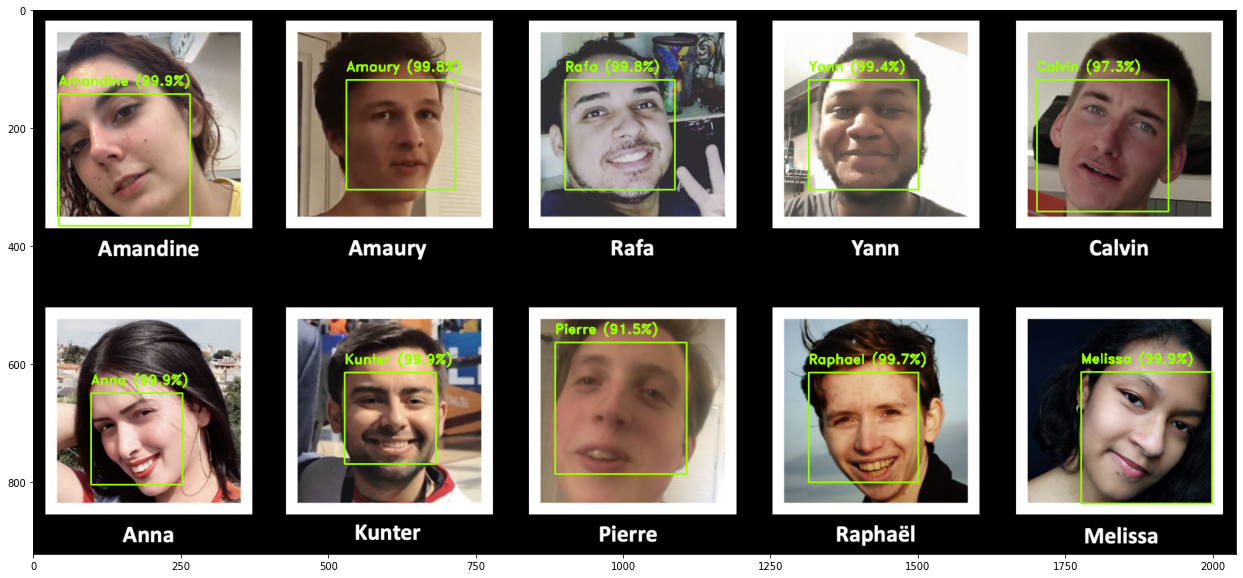

In [ ]:
image = cv2.imread("final.png")
processed = process_frame(image.copy())
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(30,10))
plt.imshow(processed)

##CONCLUSION

Pour conclure ce TP très instructif, on a obtenu un modèle de prédiction assez puissant et rapide sur la base d'un dataset assez restreint sans toutefois tomber dans l'overfitting. De plus, tout le travail effectué montre l'importance cruciale qu'a le pré-traitement des données dans le développement de réseaux de neurones performants et précis.

*©2021 Raphaël CANIN*